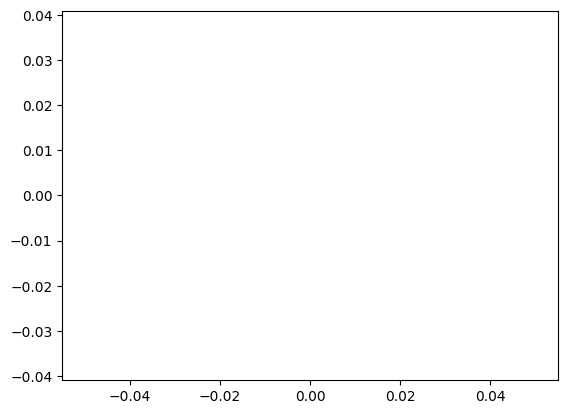

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc

def traslacion(dx, dy, dz):
    return np.array([[1, 0, 0, dx], 
                     [0, 1, 0, dy], 
                     [0, 0, 1, dz], 
                     [0, 0, 0,  1]]).T

def rotacion(ang):
    c = np.cos(ang)
    s = np.sin(ang)
    return np.array([[c, -s, 0, 0], 
                     [s,  c, 0, 0], 
                     [0,  0, 1, 0], 
                     [0,  0, 0, 1]]).T

def rotacionX(ang):
    c = np.cos(ang)
    s = np.sin(ang)
    return np.array([[1, 0,  0, 0], 
                     [0, c, -s, 0], 
                     [0, s,  c, 0], 
                     [0, 0,  0, 1]]).T

def rotacionY(ang):
    c = np.cos(ang)
    s = np.sin(ang)
    return np.array([[c, 0, -s, 0], 
                     [0, 1,  0, 0], 
                     [s, 0,  c, 0], 
                     [0, 0,  0, 1]]).T

def escala(sx, sy, sz):
    return np.array([[sx,  0,  0, 0], 
                     [ 0, sy,  0, 0], 
                     [ 0,  0, sz, 0], 
                     [ 0,  0,  0, 1]]).T

def reflexionX():
    return np.array([[1,  0, 0, 0], 
                     [0, -1, 0, 0], 
                     [0,  0, 1, 0], 
                     [0,  0, 0, 1]]).T

def reflexionY():
    return np.array([[-1, 0, 0, 0], 
                     [ 0, 1, 0, 0], 
                     [ 0, 0, 1, 0], 
                     [ 0, 0, 0, 1]]).T

def rotacionPivote(h, k, ang):
    T1 = traslacion(-h, -k, 0)
    R = rotacion(ang)
    T2 = traslacion(h, k, 0)
    return np.matmul(np.matmul(T1, R), T2) 

def escalaFijo(h, k, s):
    T1 = traslacion(-h, -k, 0)
    S = escala(s,s,s)
    T2 = traslacion(h, k, 0)
    return np.matmul(np.matmul(T1, S), T2) 

def camara(Po, Pref=np.array([0,0,0]), V=np.array([0, 1, 0])):
    T = traslacion(-Po[0], -Po[1], -Po[2])
    N = Po-Pref
    n = N / np.linalg.norm(N)
    v = V / np.linalg.norm(V)
    U = np.cross(v, n)
    u = U / np.linalg.norm(U)
    v = np.cross(n, u)
    R = np.array([[u[0], u[1], u[2], 0], 
                  [v[0], v[1], v[2], 0], 
                  [n[0], n[1], n[2], 0], 
                  [  0,    0,   0,   1]]).T
    return np.matmul(T, R)

def perspectiva(ang, aspect, near, far):
    cot = 1 / np.tan(ang*np.pi/360)
    sc  = (near+far)/(near-far)
    tr  = -2*near*far/(far-near)
    return np.array([[cot/aspect, 0,     0,   0],
                     [    0,     cot,    0,   0],
                     [    0,      0,    sc,  tr],
                     [    0,      0,    -1,   0]]).T

def adjust_persp(V):
    V[:,0] = -V[:,0]/V[:,2] 
    V[:,1] = -V[:,1]/V[:,2] 
    return V
    
def sphere(lats, lons):
    vert=[]
    ndx=[]
    dt = 2*np.pi/lons
    dp = np.pi/lats
    for i in range(lats+1):
        for j in range(lons):
            vert.append([np.cos(j*dt)*np.sin(i*dp),
                         np.cos(i*dp), 
                         np.sin(j*dt)*np.sin(i*dp), 
                         1])
    for i in range(lats):
        for j in range(lons): 
            ndx.append([i*lons+j, (i+1)*lons+(j+1)%lons, (i+1)*lons+j])
            ndx.append([i*lons+j, (i+0)*lons+(j+1)%lons, (i+1)*lons+(j+1)%lons])
    return np.array(vert), np.array(ndx, dtype='int32')


def cube():
    vert = np.array([[-1,-1,-1,1],[1,-1,-1,1],[1,1,-1,1],[-1,1,-1,1],[-1,-1,1,1],[1,-1,1,1],[1,1,1,1],[-1,1,1,1]])
    ndx  = np.array([[0,1,2],[0,2,3],[0,1,5],[0,5,4],[1,2,6],[1,6,5],[2,3,7],[2,7,6],[3,0,4],[3,4,7],[4,5,6],[4,6,7]])
    return vert, ndx

def draw_triang(ax, V, I, kolor='firebrick'):
    for i in range(I.shape[0]):
        if(V[I[i,0],2]>=0 and V[I[i,1],2]>=0 and V[I[i,2],2]>=0):
            x0 = V[I[i,0],0]
            y0 = V[I[i,0],1]
            x1 = V[I[i,1],0]
            y1 = V[I[i,1],1]
            x2 = V[I[i,2],0]
            y2 = V[I[i,2],1]
            ax.plot([x0, x1, x2, x0], [y0, y1, y2, y0], lw=0.5, color=kolor)

# Elementos
V, I = sphere(20, 10)
# Cubo
V1, I1 = cube()

# colocar elementos separados por 3 unidades y graficar
# cubo
V1[:,0] = V1[:,0]+3 
V1[:,1] = V1[:,1] 
V1[:,2] = V1[:,2]
FIGURA = np.concatenate((V, V1))
INDICES = np.concatenate((I, I1+V.shape[0]))

# plt.triplot(V[:,0], V[:,1], I, lw=0.5)
tt = plt.axis('equal')

# crear animación
fig, ax = plt.subplots()
plt.close()
graf, = ax.plot(FIGURA[:,0], FIGURA[:,1])

def rotate_figure(c, P, P1, ax1):
    # Cámara perspectiva horizontal
    mv = camara(np.array([-5+c/6, 0.2, 0.2]), np.array([100, 0.2, 0.2]), np.array([0,-1,0]))
    # mp = perspectiva(30, 1.5, 0.1, 10)
    mp = perspectiva(60, 1.5, 0.2, 10)
    mc = np.matmul(mv, mp) 
    P2 = np.matmul(P, mc)
    P3 = adjust_persp(P2)   
    P4 = np.matmul(P1, mc)
    P5 = adjust_persp(P4)   
    ax.clear()
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    # Graficar esfera
    draw_triang(ax, P3, I)
    # Graficar cubo
    draw_triang(ax, P5, I1)
    return ax1

anim = animation.FuncAnimation(fig, rotate_figure, 60, fargs=(V, V1, graf), interval=100, blit=False)

rc('animation', html='jshtml')
anim